# Ample size for full waveform

(author: B.Paetsch, date: 23.06.2020)



In [5]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

# Initial parameters
baseline_ = 16384. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [14]:
"""take gains into account for each adc value"""
"""only look at top PMTs (for position reconstruction)"""

# A waveform reader function
def Waveform(raw,eventnr):
    event = raw.get_single_event(eventnr)
    ch_top = eval(config['DEFAULT']['channels_top'])
    gain = eval(config['DEFAULT']['gains'])
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    counter = False
    #s = 0
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top:  #only top PMTs
            i = np.zeros(n_channels, dtype = int)
            for adc in p.raw_data:
                try:
                #Add the ADC value to the appropriate channel array
                    ts[ch][p.left + i[ch]] = adc
                    #print("adc: ", adc)
                    if gain[ch]!=0:
                        adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                        #print("%: ", gain[ch]/4800000)
                    else:
                        adc_corrected = np.inf #if we put 0 here, PMTs with 0 gain are taken into account for minchannel
                    #print("corrected: ",adc_corrected)
                    i[ch] = i[ch] + 1
                except IndexError:
                        #s += 1
                        counter = True
                        
                #Append all significant main channels to the list
                if adc_corrected < 15000 and ch not in channellist and ch in det_ch['tpc']:
                    channellist.append(ch)
                
                #Check which channel is the minimum channel
                if adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel, counter

In [27]:
#testing the counter (events for whom 350000 is too small as waveform size)
c = 0
cut_event_list = []
#s_list = []
for i in range (10):
    t, ts, channellist, minchannel, counter = Waveform(NG,i)
    if counter == True:
        #s_list.append(s)
        c += 1
        cut_event_list.append(i)
print(cut_event_list, "number of events: ",c ) #, ", length: ", s_list)     

#Rn220: first 50 events 
#[5, 8, 26, 27, 33, 34, 35, 44, 48, 50] 
#number of events:  10 , length:  [39098, 51570, 7656, 6406, 19504, 546884, 818719, 118394, 100947, 745822]

[] number of events:  0


For 1000 event in NG: 55 broader than 350000 (5.5%)

[24, 160, 300, 342, 385, 386, 389, 390, 392, 397, 398, 401, 404, 406, 415, 416, 417, 439, 453, 458, 464, 472, 484, 512, 554, 557, 568, 578, 609, 615, 618, 640, 651, 657, 674, 724, 744, 780, 797, 803, 807, 813, 818, 824, 830, 836, 858, 861, 910, 914, 931, 965, 978, 984, 988] number of events:  55

For 10000 events in RN220: 1170 broader than 350000 (11.7%)

[5, 8, 26, 27, 33, 34, 35, 44, 48, 50, 55, 68, 69, 76, 77, 82, 89, 93, 98, 101, 109, 130, 132, 139, 160, 165, 178, 185, 189, 199, 215, 227, 238, 247, 259, 265, 279, 303, 305, 306, 313, 326, 344, 355, 390, 409, 425, 427, 432, 443, 444, 449, 454, 463, 465, 470, 475, 479, 488, 494, 503, 514, 524, 541, 547, 550, 552, 559, 565, 574, 575, 577, 579, 609, 622, 665, 668, 681, 686, 688, 691, 696, 701, 716, 719, 726, 731, 734, 737, 740, 741, 743, 749, 763, 765, 779, 783, 784, 787, 790, 796, 812, 822, 823, 834, 836, 838, 844, 845, 860, 863, 864, 868, 870, 877, 881, 882, 892, 949, 961, 971, 989, 991, 995, 1003, 1022, 1030, 1038, 1040, 1045, 1046, 1050, 1056, 1057, 1061, 1067, 1072, 1079, 1082, 1101, 1106, 1109, 1116, 1120, 1121, 1127, 1147, 1158, 1173, 1177, 1185, 1194, 1200, 1217, 1238, 1246, 1250, 1254, 1276, 1285, 1324, 1326, 1328, 1337, 1339, 1357, 1361, 1371, 1386, 1390, 1404, 1427, 1442, 1450, 1466, 1474, 1475, 1476, 1485, 1489, 1494, 1500, 1505, 1510, 1513, 1536, 1550, 1554, 1557, 1575, 1608, 1614, 1620, 1664, 1669, 1678, 1707, 1709, 1713, 1721, 1748, 1775, 1783, 1795, 1804, 1806, 1811, 1814, 1828, 1838, 1850, 1854, 1871, 1874, 1884, 1898, 1901, 1923, 1927, 1935, 1938, 1946, 1947, 1956, 1964, 1967, 1972, 1989, 2004, 2005, 2016, 2036, 2043, 2044, 2045, 2051, 2073, 2078, 2092, 2105, 2110, 2115, 2136, 2139, 2144, 2147, 2150, 2153, 2157, 2159, 2163, 2172, 2181, 2192, 2219, 2220, 2241, 2246, 2249, 2259, 2263, 2270, 2274, 2277, 2281, 2282, 2294, 2295, 2305, 2340, 2345, 2349, 2356, 2368, 2374, 2379, 2380, 2388, 2395, 2397, 2398, 2401, 2404, 2415, 2430, 2437, 2446, 2451, 2452, 2469, 2470, 2482, 2488, 2492, 2499, 2510, 2523, 2558, 2563, 2572, 2576, 2580, 2591, 2600, 2603, 2611, 2612, 2649, 2659, 2662, 2663, 2690, 2692, 2723, 2728, 2733, 2735, 2742, 2751, 2758, 2764, 2768, 2779, 2780, 2791, 2796, 2799, 2823, 2824, 2830, 2837, 2846, 2854, 2860, 2864, 2867, 2878, 2882, 2883, 2891, 2892, 2909, 2913, 2914, 2920, 2951, 2968, 2977, 2994, 3002, 3003, 3007, 3019, 3036, 3039, 3042, 3059, 3061, 3065, 3070, 3080, 3085, 3097, 3100, 3101, 3104, 3106, 3116, 3128, 3134, 3156, 3159, 3160, 3166, 3176, 3187, 3206, 3222, 3230, 3236, 3240, 3252, 3264, 3267, 3274, 3295, 3296, 3298, 3301, 3307, 3320, 3321, 3323, 3350, 3352, 3358, 3360, 3364, 3365, 3387, 3411, 3413, 3416, 3420, 3426, 3434, 3447, 3489, 3498, 3499, 3501, 3503, 3520, 3534, 3536, 3538, 3540, 3544, 3551, 3555, 3559, 3560, 3563, 3570, 3573, 3579, 3581, 3582, 3590, 3603, 3610, 3616, 3620, 3622, 3625, 3629, 3651, 3666, 3669, 3673, 3676, 3684, 3692, 3703, 3712, 3742, 3760, 3761, 3764, 3784, 3797, 3813, 3836, 3854, 3864, 3868, 3871, 3882, 3896, 3898, 3909, 3912, 3913, 3923, 3928, 3930, 3935, 3939, 3943, 3946, 3959, 3968, 3969, 3978, 3980, 3991, 3997, 4004, 4009, 4013, 4026, 4030, 4032, 4036, 4041, 4071, 4085, 4088, 4099, 4102, 4104, 4110, 4140, 4151, 4154, 4159, 4165, 4187, 4188, 4207, 4224, 4226, 4231, 4233, 4247, 4250, 4251, 4253, 4257, 4266, 4269, 4284, 4297, 4340, 4343, 4350, 4351, 4353, 4356, 4376, 4378, 4388, 4402, 4413, 4428, 4453, 4462, 4466, 4467, 4468, 4474, 4479, 4489, 4499, 4500, 4506, 4510, 4513, 4515, 4517, 4521, 4526, 4542, 4548, 4551, 4560, 4574, 4578, 4588, 4592, 4606, 4611, 4616, 4618, 4620, 4627, 4629, 4637, 4647, 4667, 4681, 4684, 4693, 4695, 4701, 4708, 4713, 4722, 4725, 4727, 4730, 4750, 4758, 4764, 4814, 4816, 4826, 4840, 4844, 4852, 4854, 4873, 4877, 4882, 4885, 4896, 4910, 4912, 4913, 4920, 4929, 4941, 4952, 4957, 4960, 4968, 4981, 5009, 5016, 5019, 5027, 5034, 5036, 5055, 5056, 5060, 5065, 5067, 5069, 5070, 5082, 5098, 5102, 5109, 5111, 5121, 5129, 5132, 5134, 5145, 5172, 5174, 5175, 5178, 5181, 5194, 5229, 5233, 5238, 5246, 5250, 5265, 5275, 5279, 5281, 5292, 5299, 5300, 5319, 5330, 5344, 5346, 5352, 5356, 5368, 5370, 5373, 5382, 5388, 5391, 5398, 5435, 5444, 5445, 5451, 5464, 5467, 5490, 5494, 5495, 5507, 5521, 5526, 5575, 5576, 5582, 5590, 5594, 5604, 5608, 5616, 5619, 5620, 5631, 5645, 5663, 5673, 5674, 5678, 5687, 5699, 5723, 5741, 5774, 5779, 5791, 5797, 5853, 5863, 5865, 5880, 5898, 5904, 5923, 5926, 5929, 5932, 5936, 5940, 5946, 5952, 5956, 5970, 5971, 5983, 5984, 5985, 5989, 5994, 5997, 6013, 6037, 6049, 6055, 6060, 6063, 6067, 6073, 6076, 6087, 6094, 6106, 6109, 6114, 6120, 6136, 6160, 6161, 6180, 6185, 6186, 6190, 6195, 6221, 6222, 6250, 6259, 6261, 6268, 6269, 6272, 6277, 6287, 6288, 6293, 6299, 6304, 6305, 6315, 6320, 6332, 6336, 6337, 6352, 6356, 6363, 6366, 6372, 6387, 6397, 6398, 6410, 6424, 6430, 6441, 6448, 6449, 6461, 6473, 6477, 6520, 6545, 6578, 6586, 6588, 6591, 6621, 6665, 6692, 6694, 6702, 6707, 6714, 6715, 6723, 6727, 6737, 6742, 6744, 6750, 6771, 6786, 6790, 6798, 6799, 6812, 6825, 6829, 6833, 6842, 6844, 6848, 6857, 6859, 6885, 6886, 6892, 6898, 6899, 6900, 6905, 6910, 6915, 6916, 6918, 6923, 6930, 6936, 6949, 6971, 6973, 6980, 6984, 6988, 7006, 7007, 7010, 7021, 7022, 7025, 7029, 7035, 7049, 7059, 7067, 7068, 7078, 7080, 7083, 7106, 7122, 7127, 7129, 7134, 7135, 7139, 7143, 7148, 7153, 7174, 7177, 7194, 7222, 7223, 7249, 7255, 7267, 7293, 7294, 7296, 7309, 7346, 7353, 7358, 7371, 7382, 7386, 7389, 7392, 7414, 7446, 7462, 7481, 7491, 7493, 7496, 7499, 7508, 7514, 7521, 7532, 7538, 7557, 7584, 7585, 7589, 7592, 7597, 7601, 7603, 7614, 7619, 7635, 7645, 7650, 7656, 7666, 7667, 7673, 7683, 7690, 7705, 7707, 7732, 7736, 7772, 7787, 7805, 7817, 7826, 7830, 7834, 7847, 7878, 7881, 7893, 7901, 7903, 7909, 7913, 7949, 7952, 7957, 7971, 7992, 7997, 8002, 8016, 8023, 8034, 8037, 8038, 8045, 8047, 8050, 8066, 8071, 8080, 8085, 8102, 8111, 8147, 8163, 8164, 8171, 8184, 8192, 8195, 8199, 8208, 8209, 8210, 8213, 8227, 8245, 8246, 8283, 8284, 8290, 8292, 8296, 8304, 8307, 8315, 8322, 8324, 8325, 8327, 8344, 8351, 8366, 8369, 8371, 8377, 8382, 8391, 8395, 8404, 8408, 8410, 8414, 8416, 8434, 8436, 8440, 8453, 8456, 8457, 8472, 8478, 8486, 8487, 8492, 8504, 8510, 8514, 8516, 8522, 8529, 8537, 8554, 8559, 8569, 8573, 8594, 8604, 8618, 8630, 8647, 8655, 8663, 8673, 8689, 8690, 8696, 8697, 8704, 8705, 8720, 8721, 8734, 8741, 8747, 8749, 8757, 8758, 8760, 8764, 8765, 8778, 8811, 8820, 8832, 8833, 8838, 8846, 8847, 8853, 8863, 8867, 8893, 8921, 8923, 8931, 8937, 8943, 8949, 8956, 8971, 8973, 8981, 8982, 8985, 8990, 8993, 8996, 8998, 9033, 9047, 9052, 9053, 9066, 9072, 9073, 9079, 9082, 9083, 9087, 9100, 9105, 9113, 9116, 9130, 9131, 9139, 9144, 9161, 9166, 9172, 9174, 9179, 9184, 9186, 9201, 9206, 9241, 9244, 9250, 9256, 9272, 9280, 9281, 9285, 9293, 9306, 9309, 9311, 9328, 9346, 9371, 9383, 9386, 9392, 9412, 9425, 9442, 9445, 9453, 9455, 9462, 9466, 9474, 9481, 9487, 9492, 9501, 9537, 9544, 9547, 9555, 9566, 9567, 9568, 9576, 9595, 9621, 9628, 9632, 9650, 9655, 9657, 9666, 9672, 9675, 9692, 9697, 9709, 9714, 9723, 9736, 9748, 9753, 9795, 9799, 9801, 9805, 9807, 9810, 9811, 9819, 9828, 9842, 9846, 9851, 9862, 9868, 9871, 9877, 9882, 9888, 9895, 9896, 9901, 9906, 9914, 9915, 9918, 9923, 9925, 9938, 9944, 9952, 9953, 9955, 9957, 9962, 9997] number of events: 1177


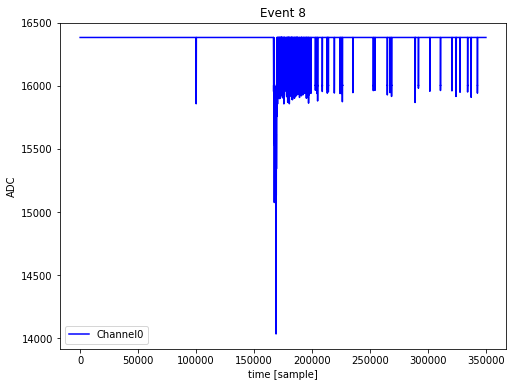

In [26]:
eventnumber = 8
Input = Waveform(Rn220,eventnumber)

%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
figs, ax = plt.subplots()
ax.plot(Input[0], Input[1][0], label='Channel' + str(0), color = 'blue')
ax.set_ylabel("ADC")
ax.set_xlabel("time [sample]")
ax.set_title('Event ' + str(eventnumber))
ax.legend()
#fname = 'BroadWaveformRn_'+str(eventnumber)+'.png'
#figs.savefig(fname, dpi = (200))

### Conclusion: 

Rn220: 11.7% of the events are broader than 350000 (1170 out of 10000)

NG: 5.5% of the events are broader than 350000 (55 out of 1000)

When looking at the according waveform, it is legible to skip these kind of events. They show many peaks close by, and implies a strong scintillation signal. (could come from a cosmic muon) 